In [ ]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from peft import PeftModel, get_peft_model, LoraConfig
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt

In [2]:


# --- 核心定义 (从主 Notebook 复制) ---
from pinyin_tokenizer import PinyinTokenizer
from stroke_tokenizer import StrokeTokenizer

class SiameseBERT(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-chinese'):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]
    
    # [新增] 补上这个缺失的方法
    def resize_token_embeddings(self, new_size):
        self.bert.resize_token_embeddings(new_size)

class TripletDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        anchor = self.data[idx]['query']
        positive = self.data[idx]['document']
        while True:
            negative_idx = random.randint(0, len(self.data) - 1)
            if negative_idx != idx:
                negative = self.data[negative_idx]['document']
                break
        return {"anchor": anchor, "positive": positive, "negative": negative}

def create_eval_collate_fn(tokenizer, max_length):
    def collate_fn(batch):
        anchors = [item['anchor'] for item in batch]
        positives = [item['positive'] for item in batch]
        negatives = [item['negative'] for item in batch]
        a_enc = tokenizer(anchors, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        p_enc = tokenizer(positives, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        n_enc = tokenizer(negatives, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        return {
            'anchor_input_ids': a_enc['input_ids'], 'anchor_attention_mask': a_enc['attention_mask'],
            'positive_input_ids': p_enc['input_ids'], 'positive_attention_mask': p_enc['attention_mask'],
            'negative_input_ids': n_enc['input_ids'], 'negative_attention_mask': n_enc['attention_mask'],
        }
    return collate_fn

print("核心定义加载完毕。")

核心定义加载完毕。


In [3]:
# --- 1. 从文件加载评估所需的数据 ---
print("正在从文件加载验证集...")
try:
    with open('val_data_50k.json', 'r', encoding='utf-8') as f:
        val_data = json.load(f)
    print(f"成功加载 {len(val_data)} 条验证集样本。")
    clean_test_dataset = TripletDataset(val_data)
except FileNotFoundError:
    print("错误: 未找到 val_data_50k.json 文件。请先运行主训练 Notebook 生成该文件。")
    val_data = None

# --- 2. 创建鲁棒性测试集 ---
typo_test_data_raw = [
    {'query': '我得了搪尿病怎么办？', 'document': '糖尿病的典型症状是三多一少，即多饮、多尿、多食和体重减轻。'},
    {'query': '高血呀怎么办？', 'document': '高血压患者应注意低盐饮食，并遵医嘱服用降压药。'},
    {'query': '心脏病有啥前兆', 'document': '胸闷、心悸、呼吸困难可能是心脏病的前兆。'},
    {'query': '怎么样才能防至感冒', 'document': '预防感冒需要勤洗手、多通风、加强锻炼。'},
    {'query': '小孩发烧物理降温', 'document': '温水擦浴、使用退热贴是婴儿物理降温的常用方法。'},
    {'query': '心肌梗塞和心肌梗死一样吗', 'document': '心肌梗死，曾称为心肌梗塞，是冠状动脉急性、持续性缺血缺氧所引起的心肌坏死。'},
]
typo_test_dataset = TripletDataset(typo_test_data_raw)
print(f"评估数据集准备完毕: clean_set ({len(val_data) if val_data else 0}), typo_set ({len(typo_test_dataset)})")

正在从文件加载验证集...
成功加载 5000 条验证集样本。
评估数据集准备完毕: clean_set (5000), typo_set (6)


In [5]:
# [替换此单元格]
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from peft import PeftModel, get_peft_model, LoraConfig
import pandas as pd
import numpy as np
import os # 确保 os 已导入

# --- 1. 定义评估函数 (不变) ---
def evaluate_model(model, tokenizer, test_dataset, batch_size, max_length, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    collate_fn = create_eval_collate_fn(tokenizer, max_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            for batch in progress_bar:
                anchor_vec = model(batch['anchor_input_ids'].to(device), batch['anchor_attention_mask'].to(device))
                positive_vec = model(batch['positive_input_ids'].to(device), batch['positive_attention_mask'].to(device))
                negative_vec = model(batch['negative_input_ids'].to(device), batch['negative_attention_mask'].to(device))
                sim_positive = F.cosine_similarity(anchor_vec, positive_vec)
                sim_negative = F.cosine_similarity(anchor_vec, negative_vec)
                correct_predictions += (sim_positive > sim_negative).sum().item()
                total_samples += len(anchor_vec)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return {"accuracy": accuracy}

# --- 2. [修正] 主评估流程 ---
modes_to_evaluate = ['baseline_lora', 'pinyin_lora', 'stroke_lora']
final_results = []
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EXPERIMENT_CONFIGS = {
    'baseline_lora': {'epochs': 10, 'batch_size': 32, 'lr': 1e-4, 'max_length': 128, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16},
    'pinyin_lora': {'epochs': 10, 'batch_size': 32, 'lr': 2e-4, 'max_length': 256, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16},
    'stroke_lora': {'epochs': 10, 'batch_size': 8, 'lr': 2e-4, 'max_length': 256, 'model_name': 'bert-base-chinese', 'patience': 2, 'lora_r': 8, 'lora_alpha': 16}
}

if val_data:
    for mode in modes_to_evaluate:
        print(f"\n--- Evaluating Model: {mode} ---")
        config = EXPERIMENT_CONFIGS[mode]
        
        # a. 动态加载或重建 Tokenizer
        tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        
        if 'pinyin' in mode:
            print("Rebuilding pinyin tokenizer...")
            custom_tokenizer = PinyinTokenizer()
            new_tokens = [t for t in custom_tokenizer.token2id.keys() if t not in tokenizer.vocab]
            tokenizer.add_tokens(new_tokens)
        elif 'stroke' in mode:
            print("Rebuilding stroke tokenizer...")
            # [修正] 使用正确的文件名，并在加载前强制检查文件是否存在
            stroke_map_file = 'autodl-tmp/zh2letter.txt' # <-- 请再次确认你的正确文件名是 zh2text.txt 还是 zh2letter.txt
            if not os.path.exists(stroke_map_file):
                raise FileNotFoundError(f"CRITICAL: Stroke mapping file '{stroke_map_file}' not found. Evaluation cannot continue.")
            
            custom_tokenizer = StrokeTokenizer(zh2text_file=stroke_map_file)
            new_tokens = [t for t in custom_tokenizer.stroke2id.keys() if t not in tokenizer.vocab]
            tokenizer.add_tokens(new_tokens)

        # b. 加载 LoRA 模型
        base_model = SiameseBERT(pretrained_model_name=config['model_name'])
        if 'baseline' not in mode:
            base_model.resize_token_embeddings(len(tokenizer))
        lora_config = LoraConfig(r=config['lora_r'], lora_alpha=config['lora_alpha'], target_modules=["query", "key", "value"], lora_dropout=0.1, bias="none")
        model = get_peft_model(base_model, lora_config)
        model.load_state_dict(torch.load(f'model_best_{mode}.pth', map_location=DEVICE))
        model = model.merge_and_unload()
        model.to(DEVICE)

        # c. 评估
        clean_metrics = evaluate_model(model, tokenizer, clean_test_dataset, config['batch_size'], config['max_length'], DEVICE)
        print(f"Accuracy on Clean Set: {clean_metrics['accuracy']:.4f}")
        typo_metrics = evaluate_model(model, tokenizer, typo_test_dataset, config['batch_size'], config['max_length'], DEVICE)
        print(f"Accuracy on Typo Set (Robustness): {typo_metrics['accuracy']:.4f}")
        
        final_results.append({"Model": mode, "Clean Set Accuracy": clean_metrics['accuracy'], "Typo Set Accuracy": typo_metrics['accuracy']})
        del model, tokenizer, base_model
        torch.cuda.empty_cache()
else:
    print("评估无法进行，因为验证集数据未成功加载。")

# --- 3. 汇总并展示结果 ---
results_df = pd.DataFrame(final_results)
print("\n\n--- Final Evaluation Summary ---")
print(results_df.to_markdown(index=False))


--- Evaluating Model: baseline_lora ---


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on Clean Set: 0.9660


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on Typo Set (Robustness): 1.0000

--- Evaluating Model: pinyin_lora ---
Rebuilding pinyin tokenizer...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on Clean Set: 0.7796


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on Typo Set (Robustness): 0.8333

--- Evaluating Model: stroke_lora ---
Rebuilding stroke tokenizer...


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

Accuracy on Clean Set: 0.7728


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on Typo Set (Robustness): 0.6667


--- Final Evaluation Summary ---
| Model         |   Clean Set Accuracy |   Typo Set Accuracy |
|:--------------|---------------------:|--------------------:|
| baseline_lora |               0.966  |            1        |
| pinyin_lora   |               0.7796 |            0.833333 |
| stroke_lora   |               0.7728 |            0.666667 |


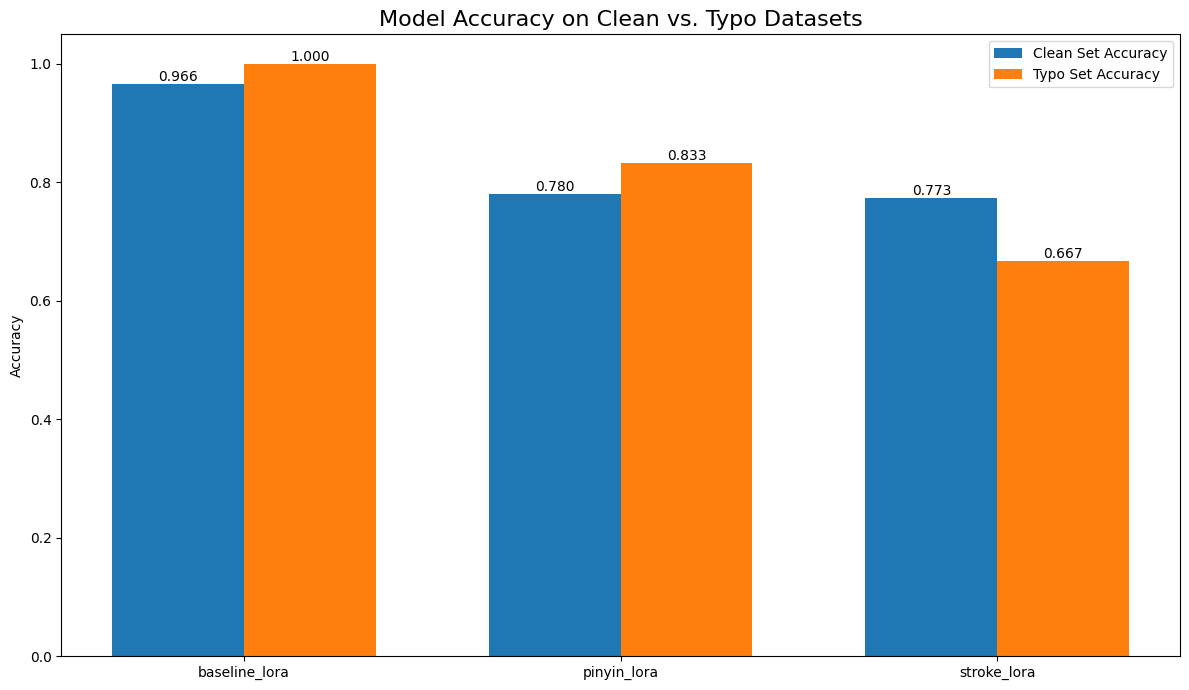

In [6]:
# --- 6. 可视化评估结果 ---
if final_results:
    # 设置模型顺序和颜色，以匹配之前的 loss 图
    results_df['Model'] = pd.Categorical(results_df['Model'], categories=['baseline_lora', 'pinyin_lora', 'stroke_lora'], ordered=True)
    results_df = results_df.sort_values('Model')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # 绘制分组条形图
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_width = 0.35
    index = np.arange(len(results_df['Model']))

    bar1 = ax.bar(index - bar_width/2, results_df['Clean Set Accuracy'], bar_width, label='Clean Set Accuracy', color=colors[0])
    bar2 = ax.bar(index + bar_width/2, results_df['Typo Set Accuracy'], bar_width, label='Typo Set Accuracy', color=colors[1])

    ax.set_ylabel('Accuracy')
    ax.set_title('Model Accuracy on Clean vs. Typo Datasets', fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels(results_df['Model'])
    ax.legend()
    
    # 在条形图上显示具体数值
    for bar in bar1 + bar2:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')

    fig.tight_layout()
    plt.savefig('evaluation_accuracy.png')
    plt.show()